In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/House-Sales/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/House-Sales'

---

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/SalesRecord.csv")
      .drop(['EnclosedPorch', 'WoodDeckSF', 'SalePrice'], axis=1)
      )
print(df.shape)
df.head(3)

(1460, 21)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,Gd,8450,65.0,196.0,61,5,7,856,2003,2003
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,TA,9600,80.0,0.0,0,8,6,1262,1976,1976
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,Gd,11250,68.0,162.0,42,5,7,920,2001,2002


In [7]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


def PipelineCluster():
    pipeline_base = Pipeline([
         ('median', MeanMedianImputer(imputation_method='median',
                                     variables=['2ndFlrSF', 'BedroomAbvGr','GarageYrBlt', 
                                                'LotFrontage', 'MasVnrArea'])),

        ('categorical_imputer', CategoricalImputer(imputation_method='missing',
                                                  fill_value='Missing',
                                                  variables=['GarageFinish', 'BsmtFinType1'])),
        
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'GarageFinish', 'KitchenQual', 'BsmtFinType1'])),
        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=21, random_state=0)),

        ("model", KMeans(n_clusters=50, random_state=0)),
        
        ('drop_features', DropFeatures(features_to_drop = ['EnclosedPorch', 'WoodDeckSF',])),

    ])
    return pipeline_base

In [8]:
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df)

print(df_pca.shape,'\n', type(df_pca))

(1460, 21) 
 <class 'numpy.ndarray'>


* The 12 components explain 88.13% of the data 



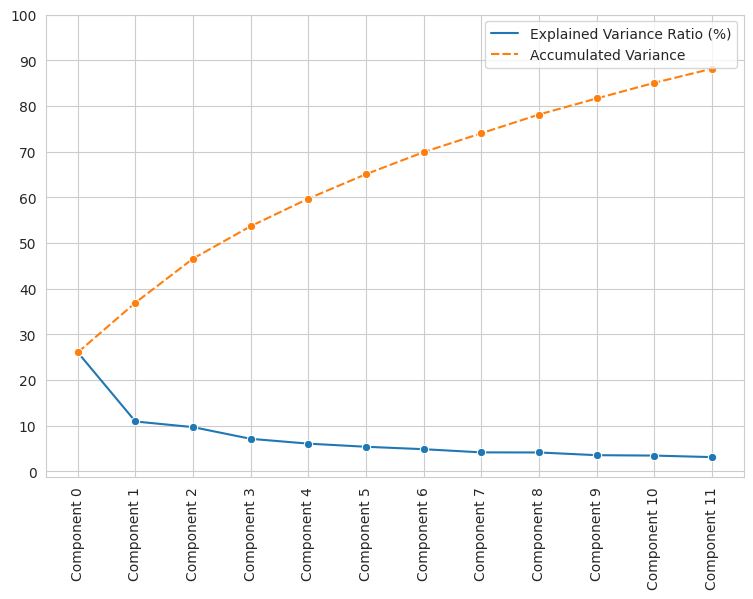

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

n_components = 12


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

* The 6 components explain 65.05% of the data 



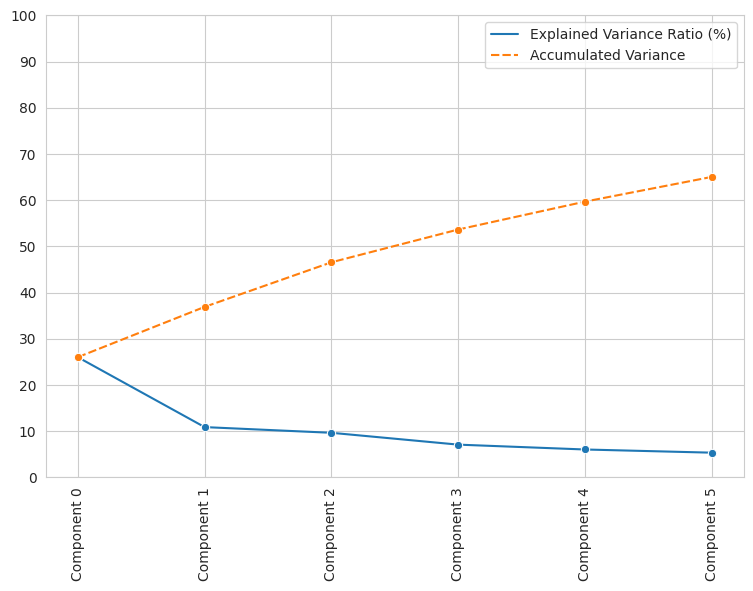

In [10]:
pca_components_analysis(df_pca=df_pca,n_components=6)

In [11]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df)

print(df_analysis.shape,'\n', type(df_analysis))

(1460, 50) 
 <class 'numpy.ndarray'>


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


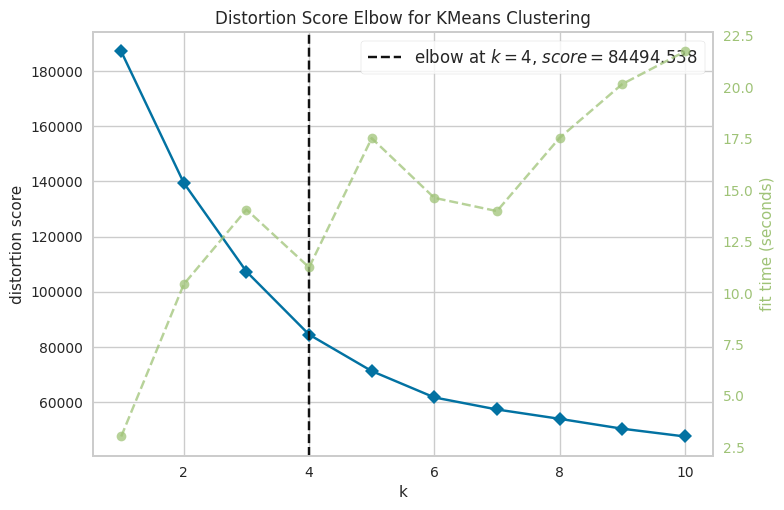

In [12]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11)) # 11 is not inclusive, it will plot until 10
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

=== Average Silhouette Score for different number of clusters ===


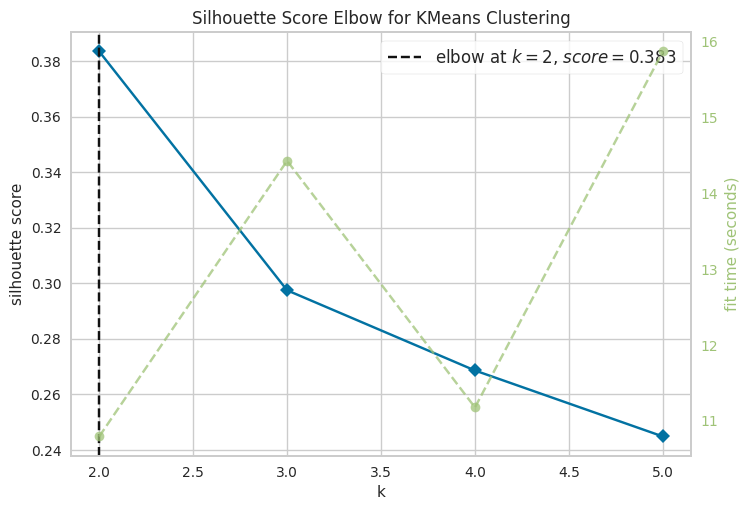



=== Silhouette plot for 2 Clusters ===


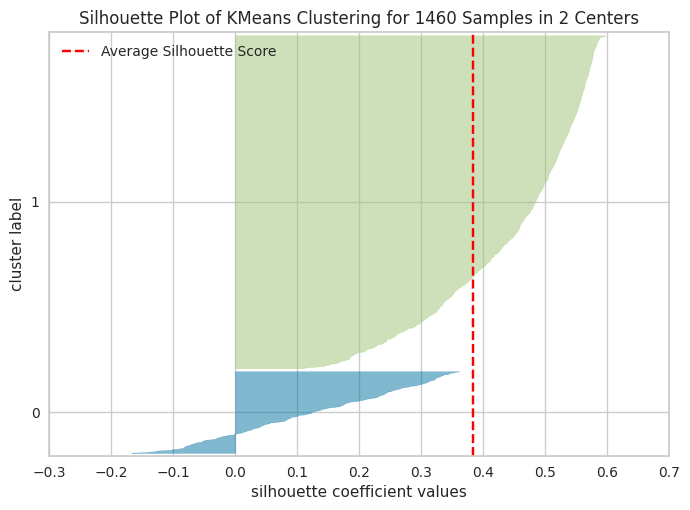



=== Silhouette plot for 3 Clusters ===


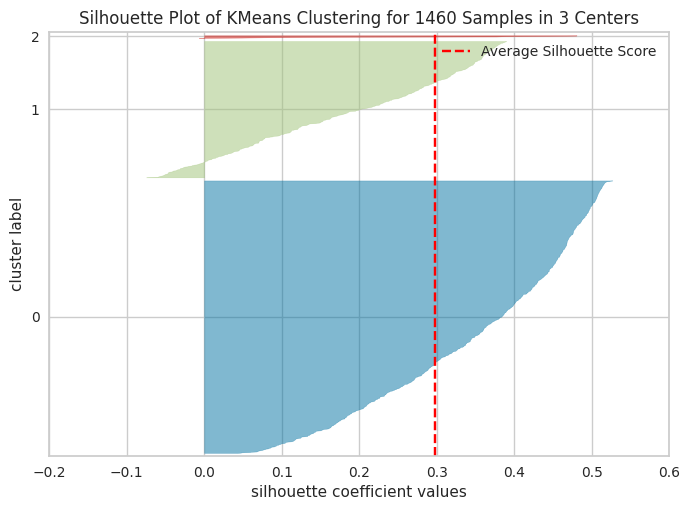



=== Silhouette plot for 4 Clusters ===


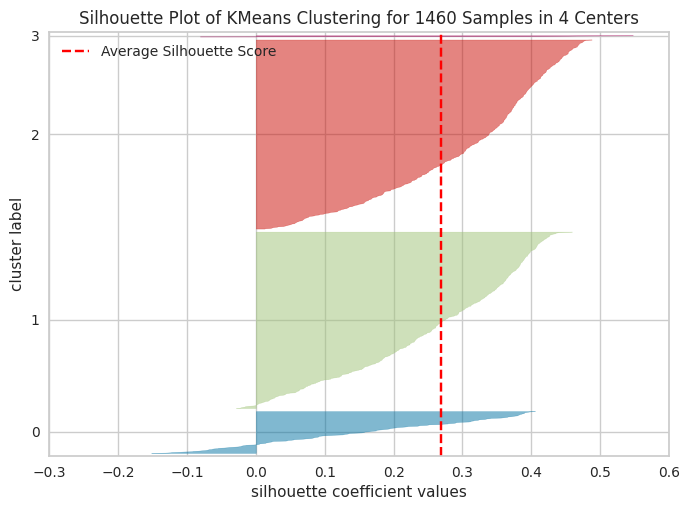



=== Silhouette plot for 5 Clusters ===


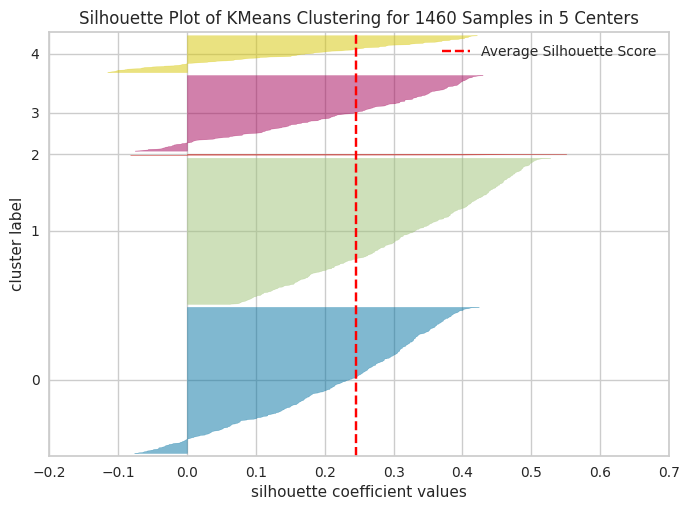

In [13]:
from yellowbrick.cluster import SilhouetteVisualizer

# 6 is not inclusive, it will stop at 5
n_cluster_start, n_cluster_stop = 2, 6

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")

In [14]:
X = df.copy()
print(X.shape)
X.head(10)

(1460, 21)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,Gd,8450,65.0,196.0,61,5,7,856,2003,2003
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,TA,9600,80.0,0.0,0,8,6,1262,1976,1976
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,Gd,11250,68.0,162.0,42,5,7,920,2001,2002
3,961,NaN,NaN,No,216,ALQ,540,642,Unf,1998.0,...,Gd,9550,60.0,0.0,35,5,7,756,1915,1970
4,1145,NaN,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,Gd,14260,84.0,350.0,84,5,8,1145,2000,2000
5,796,566.0,1.0,No,732,GLQ,64,480,Unf,1993.0,...,TA,14115,85.0,0.0,30,5,5,796,1993,1995
6,1694,0.0,3.0,Av,1369,GLQ,317,636,RFn,2004.0,...,Gd,10084,75.0,186.0,57,5,8,1686,2004,2005
7,1107,983.0,3.0,Mn,859,ALQ,216,484,NaN,1973.0,...,TA,10382,NaN,240.0,204,6,7,1107,1973,1973
8,1022,752.0,2.0,No,0,Unf,952,468,Unf,1931.0,...,TA,6120,51.0,0.0,0,5,7,952,1931,1950
9,1077,0.0,2.0,No,851,GLQ,140,205,RFn,1939.0,...,TA,7420,50.0,0.0,4,6,5,991,1939,1950


In [17]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

TypeError: X is not a pandas dataframe. The dataset should be a pandas dataframe.

In [18]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,Clusters
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,2
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,48
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,2


* Clusters frequencies 
    Clusters
7       0.04
22      0.04
43      0.04
28      0.04
17      0.04
3       0.03
2       0.03
5       0.03
18      0.03
9       0.03
48      0.03
6       0.03
39      0.03
1       0.03
23      0.03
33      0.03
14      0.03
47      0.02
10      0.02
21      0.02
42      0.02
30      0.02
19      0.02
38      0.02
24      0.02
36      0.02
26      0.02
41      0.02
16      0.02
11      0.02
34      0.02
45      0.02
20      0.01
15      0.01
4       0.01
31      0.01
46      0.01
40      0.01
8       0.01
32      0.01
49      0.01
44      0.01
27      0.01
37      0.00
13      0.00
29      0.00
0       0.00
25      0.00
35      0.00
12      0.00 




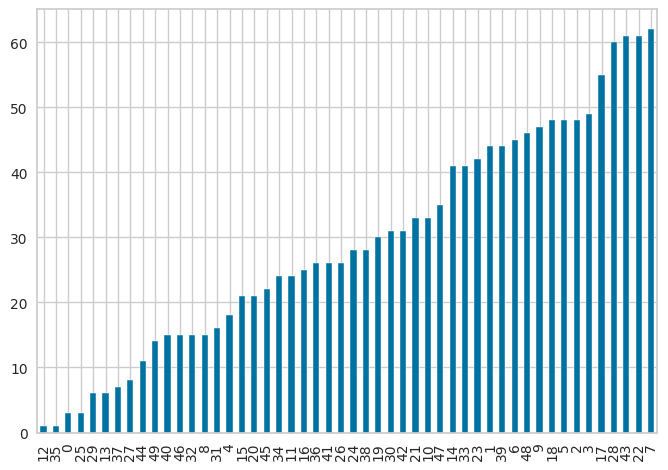

In [19]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

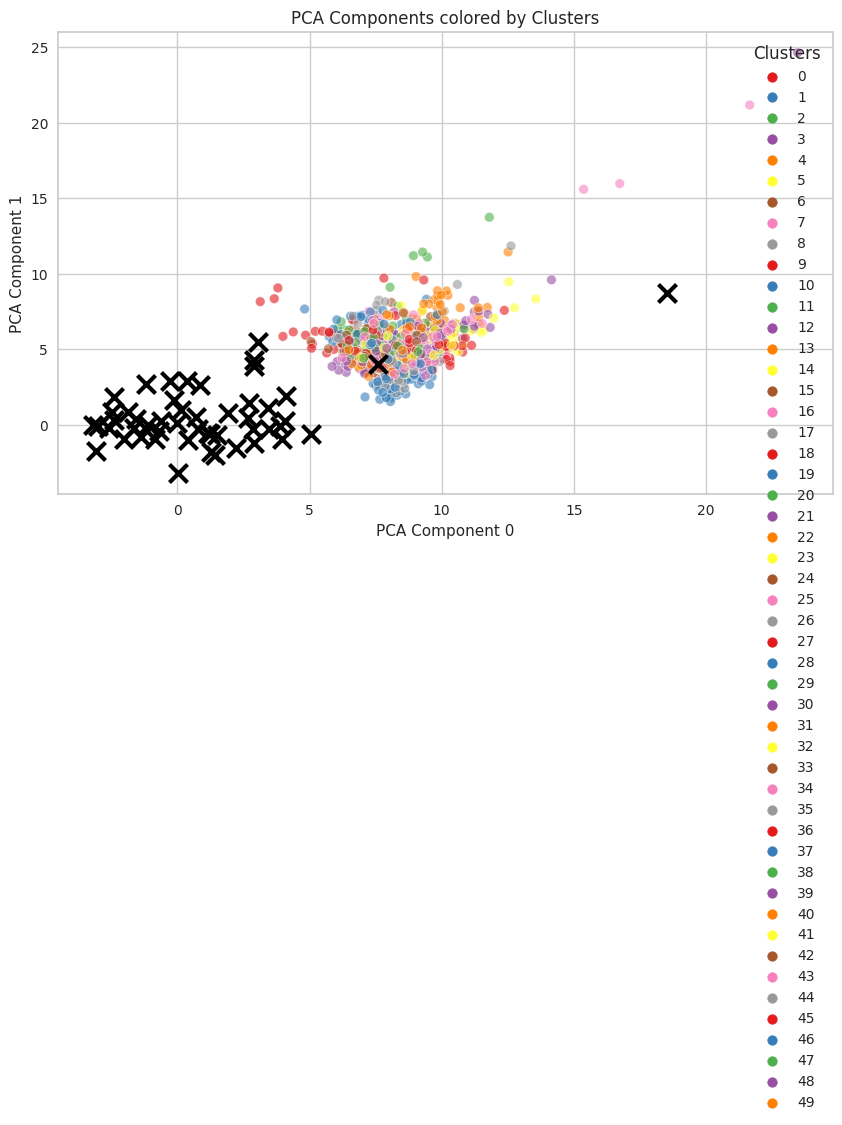

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_analysis[:, 0], y=df_analysis[:, 1],
                hue=X['Clusters'], palette='Set1', alpha=0.6)
plt.scatter(x=pipeline_cluster['model'].cluster_centers_[:, 0], y=pipeline_cluster['model'].cluster_centers_[:, 1],
            marker="x", s=169, linewidths=3, color="black")
plt.xlabel("PCA Component 0")
plt.ylabel("PCA Component 1")
plt.title("PCA Components colored by Clusters")
plt.show()

In [21]:
cluster_predictions_with_all_variables = X['Clusters']
cluster_predictions_with_all_variables

0        2
1       48
2        2
3       24
4        9
        ..
1455    33
1456    31
1457    36
1458    47
1459    43
Name: Clusters, Length: 1460, dtype: int32

In [22]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,Clusters
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,2
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,48
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,2


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Clusters'], axis=1),
    df_clf['Clusters'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, X_test.shape)

(1168, 21) (292, 21)


In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import OrdinalEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from feature_engine.imputation import CategoricalImputer
from sklearn.tree import DecisionTreeClassifier  # Import DecisionTreeClassifier
from feature_engine.selection import DropFeatures  # Import DropFeatures

def PipelineClf2ExplainClusters():
    pipeline_base = Pipeline([

        ('median', MeanMedianImputer(imputation_method='median',
                                     variables=['2ndFlrSF', 'BedroomAbvGr','GarageYrBlt', 
                                                'LotFrontage', 'MasVnrArea'])),
        
        ('categorical_imputer', CategoricalImputer(imputation_method='missing',
                                                  fill_value='Missing',
                                                  variables=['GarageFinish', 'BsmtFinType1'])),
        
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'GarageFinish', 'KitchenQual', 'BsmtFinType1'])),
        ("scaler", StandardScaler()),
        
        ('feat_selection', SelectFromModel(estimator=DecisionTreeClassifier(random_state=0))),
                
        ('model', DecisionTreeClassifier(random_state=0)),  # Add comma here

    ])
    return pipeline_base

PipelineClf2ExplainClusters()



Pipeline(steps=[('median',
                 MeanMedianImputer(variables=['2ndFlrSF', 'BedroomAbvGr',
                                              'GarageYrBlt', 'LotFrontage',
                                              'MasVnrArea'])),
                ('categorical_imputer',
                 CategoricalImputer(variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'GarageFinish',
                                           'KitchenQual', 'BsmtFinType1'])),
                ('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=DecisionTreeClassifier(random_state=0))),
                ('model', DecisionTreeClassifier(random_state=0))])

In [37]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train, y_train)

Pipeline(steps=[('median',
                 MeanMedianImputer(variables=['2ndFlrSF', 'BedroomAbvGr',
                                              'GarageYrBlt', 'LotFrontage',
                                              'MasVnrArea'])),
                ('categorical_imputer',
                 CategoricalImputer(variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'GarageFinish',
                                           'KitchenQual', 'BsmtFinType1'])),
                ('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=DecisionTreeClassifier(random_state=0))),
                ('model', DecisionTreeClassifier(random_state=0))])

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        34
           2       1.00      1.00      1.00        37
           3       1.00      1.00      1.00        39
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00        36
           6       1.00      1.00      1.00        35
           7       1.00      1.00      1.00        49
           8       1.00      1.00      1.00        13
           9       1.00      1.00      1.00        29
          10       1.00      1.00      1.00        25
          11       1.00      1.00      1.00        17
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00        36
          15       1.00      1.00      1.00        17
          16       1.00      1.00      1.00        18
          17       1.00      1.00      1.00        46
          18       1.00    

In [39]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           1       0.56      0.50      0.53        10
           2       0.77      0.91      0.83        11
           3       0.17      0.10      0.12        10
           4       0.40      0.40      0.40         5
           5       0.64      0.75      0.69        12
           6       0.38      0.50      0.43        10
           7       0.70      0.54      0.61        13
           8       0.50      0.50      0.50         2
           9       0.50      0.39      0.44        18
          10       0.09      0.12      0.11         8
          11       0.43      0.43      0.43         7
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         5
          15       0.20      0.25      0.22         4
          16       0.71      0.71      0.71         7
          17       0.25      0.11      0.15         9
          18       0.33    

/home/codeany/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codeany/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codeany/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codeany/.local/lib/python3.8/site-packa

* These are the 9 most important features in descending order. The model was trained on them: 
['TotalBsmtSF', 'YearBuilt', 'BsmtFinType1', 'GrLivArea', 'GarageArea', 'LotArea', 'BsmtExposure', 'GarageFinish', '2ndFlrSF'] 



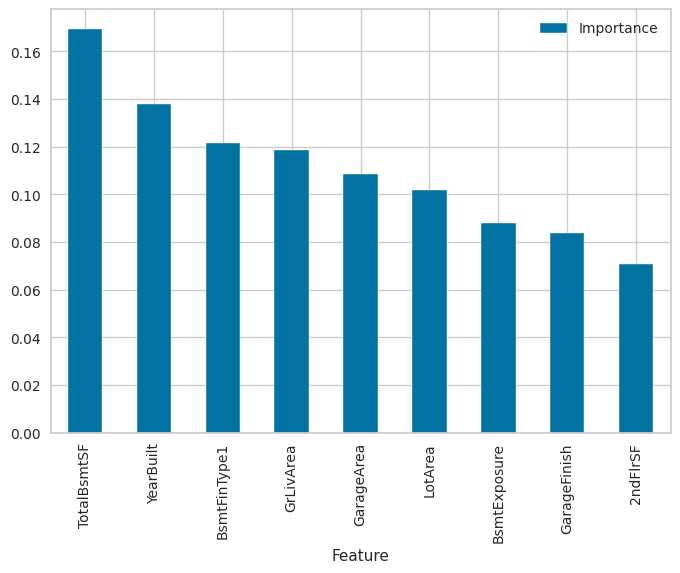

In [40]:
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_cluster.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support()],
    'Importance': pipeline_clf_cluster['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in importance order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features} \n")
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

In [41]:
best_features_pipeline_all_variables = best_features
best_features_pipeline_all_variables

['TotalBsmtSF',
 'YearBuilt',
 'BsmtFinType1',
 'GrLivArea',
 'GarageArea',
 'LotArea',
 'BsmtExposure',
 'GarageFinish',
 '2ndFlrSF']

In [42]:
def DescriptionAllClusters(df, decimal_points=3):

    DescriptionAllClusters = pd.DataFrame(
        columns=df.drop(['Clusters'], axis=1).columns)
    # iterate on each cluster , calls Clusters_IndividualDescription()
    for cluster in df.sort_values(by='Clusters')['Clusters'].unique():

        EDA_ClusterSubset = df.query(
            f"Clusters == {cluster}").drop(['Clusters'], axis=1)
        ClusterDescription = Clusters_IndividualDescription(
            EDA_ClusterSubset, cluster, decimal_points)
        DescriptionAllClusters = DescriptionAllClusters.append(
            ClusterDescription)

    DescriptionAllClusters.set_index(['Cluster'], inplace=True)
    return DescriptionAllClusters

def Clusters_IndividualDescription(EDA_Cluster, cluster, decimal_points):

    ClustersDescription = pd.DataFrame(columns=EDA_Cluster.columns)

    for col in EDA_Cluster.columns:

        try: 

            if EDA_Cluster[col].dtypes == 'object':

                top_frequencies = EDA_Cluster.dropna(
                    subset=[col])[[col]].value_counts(normalize=True).nlargest(n=3)
                Description = ''

                for x in range(len(top_frequencies)):
                    freq = top_frequencies.iloc[x]
                    category = top_frequencies.index[x][0]
                    CategoryPercentage = int(round(freq*100, 0))
                    statement = f"'{category}': {CategoryPercentage}% , "
                    Description = Description + statement

                ClustersDescription.at[0, col] = Description[:-2]

            elif EDA_Cluster[col].dtypes in ['float', 'int']:
                DescStats = EDA_Cluster.dropna(subset=[col])[[col]].describe()
                Q1 = round(DescStats.iloc[4, 0], decimal_points)
                Q3 = round(DescStats.iloc[6, 0], decimal_points)
                Description = f"{Q1} -- {Q3}"
                ClustersDescription.at[0, col] = Description

        except Exception as e:
            ClustersDescription.at[0, col] = 'Not available'
            print(
                f"** Error Exception: {e} - cluster {cluster}, variable {col}")

    ClustersDescription['Cluster'] = str(cluster)

    return ClustersDescription

In [43]:
import plotly.express as px


def cluster_distribution_per_variable(df, target):
    """
    The data should have 2 variables, the cluster predictions and
    the variable you want to analyze with, in this case we call "target".
    We use plotly express to create 2 plots:
    Cluster distribution across the target.
    Relative presence of the target level in each cluster.
    """
    df_bar_plot = df.value_counts(["Clusters", target]).reset_index()
    df_bar_plot.columns = ['Clusters', target, 'Count']
    df_bar_plot[target] = df_bar_plot[target].astype('object')

    print(f"Clusters distribution across {target} levels")
    fig = px.bar(df_bar_plot, x='Clusters', y='Count',
                 color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.show(renderer='colab')

    df_relative = (df
                   .groupby(["Clusters", target])
                   .size()
                   .groupby(level=0)
                   .apply(lambda x:  100*x / x.sum())
                   .reset_index()
                   .sort_values(by=['Clusters'])
                   )
    df_relative.columns = ['Clusters', target, 'Relative Percentage (%)']

    print(f"Relative Percentage (%) of {target} in each cluster")
    fig = px.line(df_relative, x='Clusters', y='Relative Percentage (%)',
                  color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.update_traces(mode='markers+lines')
    fig.show(renderer='colab')
 

In [44]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
print(df_cluster_profile.shape)
df_cluster_profile.head(3)

(1460, 10)


,TotalBsmtSF,YearBuilt,BsmtFinType1,GrLivArea,GarageArea,LotArea,BsmtExposure,GarageFinish,2ndFlrSF,Clusters
0,856,2003,GLQ,1710,548,8450,No,RFn,854.0,2
1,1262,1976,ALQ,1262,460,9600,Gd,RFn,0.0,48
2,920,2001,GLQ,1786,608,11250,Mn,RFn,866.0,2


In [48]:
df_sales = pd.read_csv("outputs/datasets/collection/SalesRecord.csv").filter(['SalePrice'])
df_sales['SalePrice'] = df_sales['SalePrice']
df_sales.head(3)

,SalePrice
0,208500
1,181500
2,223500


In [49]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df=pd.concat([df_cluster_profile,df_sales], axis=1), decimal_points=0)
clusters_profile

/tmp/ipykernel_4790/2106555119.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(
/tmp/ipykernel_4790/2106555119.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(
/tmp/ipykernel_4790/2106555119.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(
/tmp/ipykernel_4790/2106555119.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(
/tmp/ipykernel_4790/2106555119.py:12: FutureWarning: The frame.append method is depr

,TotalBsmtSF,YearBuilt,BsmtFinType1,GrLivArea,GarageArea,LotArea,BsmtExposure,GarageFinish,2ndFlrSF,SalePrice
Cluster,,,,,,,,,,
0,918.0 -- 1288.0,1886.0 -- 1914.0,"'Unf': 67% , 'Rec': 33%",3470.0 -- 3550.0,855.0 -- 942.0,16243.0 -- 20668.0,"'Mn': 67% , 'No': 33%",'Unf': 100%,1498.0 -- 1668.0,338000.0 -- 428000.0
1,1237.0 -- 1565.0,1959.0 -- 1968.0,"'Unf': 60% , 'Rec': 15% , 'ALQ': 10%",1368.0 -- 1684.0,440.0 -- 528.0,9593.0 -- 11726.0,"'No': 93% , 'Av': 5% , 'Gd': 2%","'Unf': 51% , 'RFn': 44% , 'Fin': 3%",0.0 -- 0.0,139400.0 -- 165000.0
2,788.0 -- 970.0,1996.0 -- 2002.0,"'GLQ': 92% , 'ALQ': 8%",1686.0 -- 1948.0,482.0 -- 593.0,8459.0 -- 11383.0,"'No': 85% , 'Gd': 6% , 'Av': 4%","'RFn': 80% , 'Unf': 15% , 'Fin': 5%",833.0 -- 944.0,196000.0 -- 235250.0
3,651.0 -- 876.0,1918.0 -- 1932.0,"'Unf': 67% , 'BLQ': 13% , 'ALQ': 7%",1111.0 -- 1601.0,216.0 -- 288.0,6000.0 -- 10200.0,"'No': 94% , 'Mn': 6%","'Unf': 89% , 'None': 4% , 'RFn': 4%",175.0 -- 668.0,112000.0 -- 155000.0
4,522.0 -- 695.0,1935.0 -- 1970.0,"'GLQ': 29% , 'ALQ': 14% , 'BLQ': 14%",630.0 -- 853.0,0.0 -- 302.0,2422.0 -- 9328.0,"'Av': 50% , 'No': 17% , 'None': 17%","'None': 54% , 'Unf': 31% , 'Fin': 15%",0.0 -- 0.0,84600.0 -- 117625.0
5,1233.0 -- 1370.0,2003.0 -- 2006.0,"'Unf': 51% , 'GLQ': 44% , 'ALQ': 4%",1252.0 -- 1419.0,430.0 -- 528.0,3562.0 -- 8800.0,"'No': 62% , 'Av': 21% , 'Mn': 10%","'Fin': 56% , 'RFn': 32% , 'Unf': 12%",0.0 -- 0.0,172312.0 -- 200731.0
6,1208.0 -- 1478.0,1993.0 -- 2005.0,"'GLQ': 91% , 'ALQ': 9%",1241.0 -- 1593.0,472.0 -- 586.0,5063.0 -- 12327.0,"'No': 67% , 'Gd': 24% , 'Av': 4%","'Fin': 67% , 'RFn': 17% , 'Unf': 14%",0.0 -- 0.0,180000.0 -- 245500.0
7,728.0 -- 936.0,1997.0 -- 2004.0,"'Unf': 70% , 'GLQ': 23% , 'ALQ': 6%",1484.0 -- 1929.0,412.0 -- 528.0,8124.0 -- 11077.0,"'No': 98% , 'Gd': 2%",'Fin': 100%,728.0 -- 930.0,176125.0 -- 224375.0
8,1152.0 -- 1608.0,2002.0 -- 2006.0,"'Unf': 85% , 'GLQ': 15%",2493.0 -- 2845.0,656.0 -- 815.0,11132.0 -- 14306.0,"'No': 53% , 'Av': 20% , 'Gd': 20%","'Fin': 93% , 'RFn': 7%",1116.0 -- 1330.0,286000.0 -- 424390.0


In [ ]:
df_cluster_vs_churn=  df_churn.copy()
df_cluster_vs_churn['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_churn, target='Churn')